# Deep Facial Recognition App Setup

1. Install Dependencies:

        pip install tensorflow
        pip install opencv-python


2. Import Dependencies
3. Set GPU Growth
4. Create Folder Structure
5. Collect Positive and Anchors
6. Untar labelled Faces in the wild Dataset
7. Load and Process Images

In [7]:
#Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [8]:
#Import tensorflow dependencis - Functional API
#Three important classes that we have got here is Model Layer Input
#Flatten: flattens down into single dimension for the given input layer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D,Dense,MaxPooling2D,Flatten,Input

In [9]:
# Setting GPU Growth
#Avoid out of memory error by setting Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [10]:
 #Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [11]:
#Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [12]:
#Collect Poitive and Negative Data

In [13]:
#Uncompress for GZ labelled Faces in the wild Dataset
!tar -xf lfw.tgz

In [14]:
# Move lfw images to the following repo data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [15]:
#Import uuid library to generate unique image names
import uuid #universally unique identifiers

In [16]:
#Collect Positive and Anchor Image
#250 x 250
# Establish a connection to the web camera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    #cut pixel to 250 x 250
    frame = frame[120:120+250,200:200+250,:]
    
    #collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create unique file path
        imgname =  os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
    #collect positiveq
    if cv2.waitKey(1) & 0XFF == ord('p'):
         #create unique file path
        imgname =  os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname,frame)
    
    #show image back to screen
    cv2.imshow('Image Collection', frame)
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
#Relaese the web cam
cap.release()
#Destroy the image show frame
cv2.destroyAllWindows()

In [17]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(120)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(120)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(120)


In [18]:
anchor.as_numpy_iterator().next()

b'data\\anchor\\51ad3d41-edb2-11ee-a3ea-8cec4b2c9b09.jpg'

# Preprocessing - Scale and Resize

In [19]:
def preprocess(file_path):
    #Read in image from file path
    byte_img = tf.io.read_file(file_path)
    #Load in the image
    img = tf.io.decode_jpeg(byte_img)
    #preprocessing -resizing to be 100 x 100 x3
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img

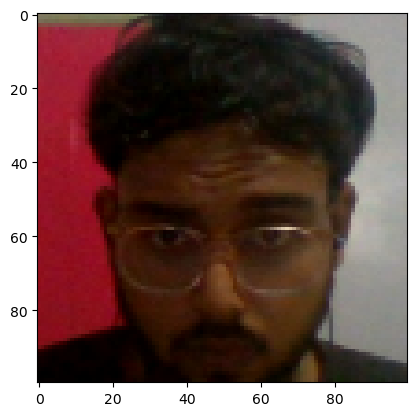

In [20]:
img = preprocess('data\\anchor\\87280a0e-edb2-11ee-9f75-8cec4b2c9b09.jpg')
plt.imshow(img)
#img.numpy().max()

# Create Labelled Dataset

In [21]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [22]:
samples = data.as_numpy_iterator()
example = samples.next()

# Build Train and Test Partition

In [23]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)

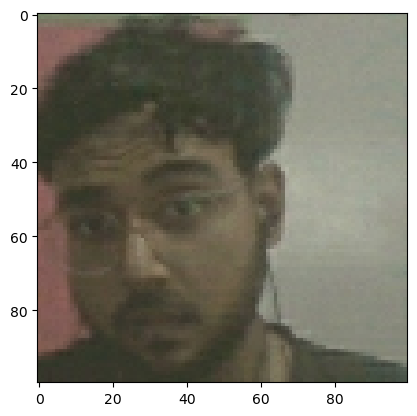

In [24]:
#grabbing one iterator from iterator
res = preprocess_twin(*example)
len(res)
plt.imshow(res[1])

In [25]:
res[2]

1.0

In [26]:
#build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

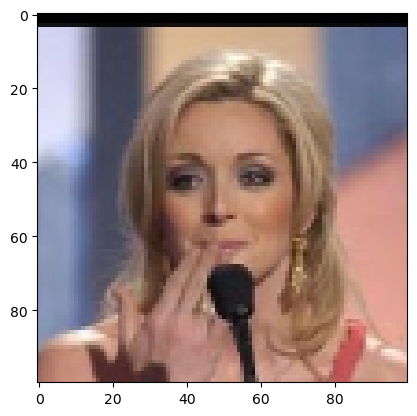

In [27]:
samples = data.as_numpy_iterator()
plt.imshow(samples.next()[0])
plt.imshow(samples.next()[1]); #Ideally means negative class

In [28]:
#Training partition
train_data = data.take(round(len(data)*.7)) #70 percent
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [29]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [30]:
train_samples = train_data.as_numpy_iterator()
train_sample= train_samples.next()
len(train_sample[0])


16

In [31]:
#Training partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))

In [32]:
test_data

<_TakeDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [33]:
len(test_data)

71

In [34]:
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

# Model Engineering

 # Build Embedding Layer

In [35]:
def make_embedding():
    #According to paper building up the first layer
    inp = Input(shape=(100,100,3),name='input_image')
    
    #First Block
    
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    # we need to keep padding same inroder to replicate the similar app to check
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    #Second Block
    
    c2 = Conv2D(128,(7,7),activation='relu')(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    #Third Block
    
    c3 = Conv2D(128,(4,4),activation='relu')(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    # Final Embedding block
    
    c4 = Conv2D(256,(4,4),activation='relu')(m3)
    f1 = Flatten()(c4) #9216 units = 6*6*256
    d1 = Dense(4096,activation='sigmoid')(f1)
     
    return Model(inputs=[inp],outputs=d1,name='embedding')
    

In [36]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

# Build Distance Layer

In [37]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
#l1 = L1Dist()

# Make Siamese Model

In [39]:
def make_siamese_model():
    
    #Anchor image input
    input_image = Input(name='input_img',shape=(100,100,3))
    
    validation_image = Input(name='validation_img',shape=(100,100,3))
    #Combine the siamese distance component
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    #Classification layer
    classifier = Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs=classifier,name='SiameseNetwork')

In [40]:
siamese_model=make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist (L1Dist)              │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

# Setup Loss and Optimizer

In [41]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
#Using Adam Optimizer
opt = tf.keras.optimizers.Adam(1e-4)

# Establish Checkpoints

In [43]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model= siamese_model)

# Build Train Step Function

In [44]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        X = batch[:2]
        y=batch[2] #labelled set
        # Forware pass
        yhat = siamese_model(X,training=True)#To activate to some layers thats why true
        #Calculate loss
        loss = binary_cross_loss(y,yhat)#passing ytrue and ypred value
    #gradient calculate
    print(loss)
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    #Calculate updated weight and apply to siamese model
    #The optimizer here is calculating and propagating the new weights using the Adams optimisation algo
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss   
        

# Build Train Loop


In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [334]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train Model

In [238]:
EPOCHS = 50
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepstep
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
10/11 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 78s 7s/step
0.7164859 0.29113925 1.0

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step
9.249533e-05 1.0 1.0

 Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step
0.036698166 0.97619045 1.0

 Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step
0.0050589354 1.0 1.0

 Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step
0.0038326464 1.0 1.0

 Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━

0.005563962 1.0 1.0

 Epoch 28/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step
0.0003492734 1.0 1.0

 Epoch 29/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step
0.008525606 1.0 1.0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step
2.371757e-06 1.0 1.0

 Epoch 38/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step
0.00022552935 1.0 1.0

 Epoch 39/50
1/1 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 6s/step
2.6152988e-05 1.0 1.0

 Epoch 47/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 61s 5s/step
1.676993e-06 1.0 1.0

 Epoch 48/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━

# Evaluation of Model

In [46]:
from tensorflow.keras.metrics import Precision,Recall

In [47]:
#Get a batch of test data
test_input,test_val,y_true = test_data.as_numpy_iterator().next()
test_input.shape,test_val.shape

((16, 100, 100, 3), (16, 100, 100, 3))

In [48]:
y_hat = siamese_model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [49]:
test_input.shape

(16, 100, 100, 3)

In [50]:
test_val.shape

(16, 100, 100, 3)

In [51]:
#post processing
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]

In [52]:
y_true

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
      dtype=float32)

# Calculate Metrics

In [53]:
#Creating a metric object
m = Recall()
# Calculating the recall value
m.update_state(y_true,y_hat)

In [54]:
m.result().numpy()

0.5714286

In [55]:
m=Precision()
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

In [56]:
r = Recall()
p = Precision()

for test_input,test_val,y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input,test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)
    
print(r.result().numpy(),p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
0.3529412 0.9230769


# Viz Results

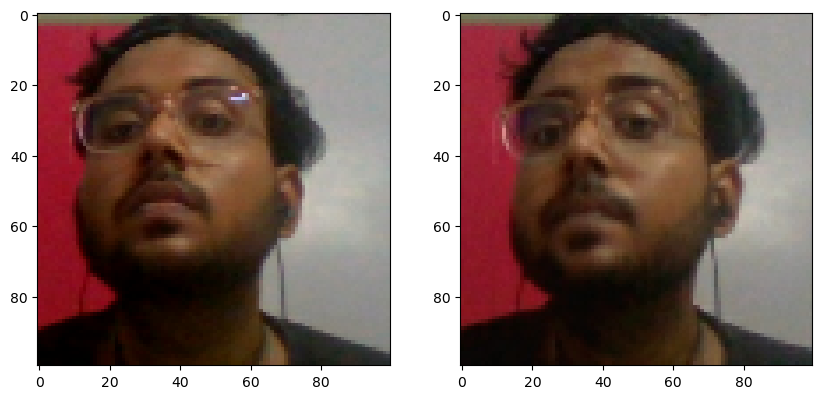

In [57]:
#Set plot size
plt.figure(figsize=(10,8))
#set first plot
plt.subplot(1,2,1)
plt.imshow(test_input[1])
#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])
#Renders cleanly
plt.show()

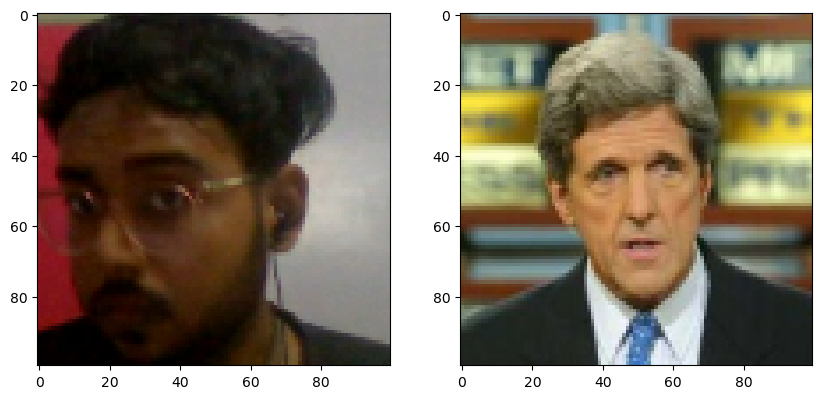

In [58]:
#Set plot size
plt.figure(figsize=(10,8))
#set first plot
plt.subplot(1,2,1)
plt.imshow(test_input[2])
#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])
#Renders cleanly
plt.show()

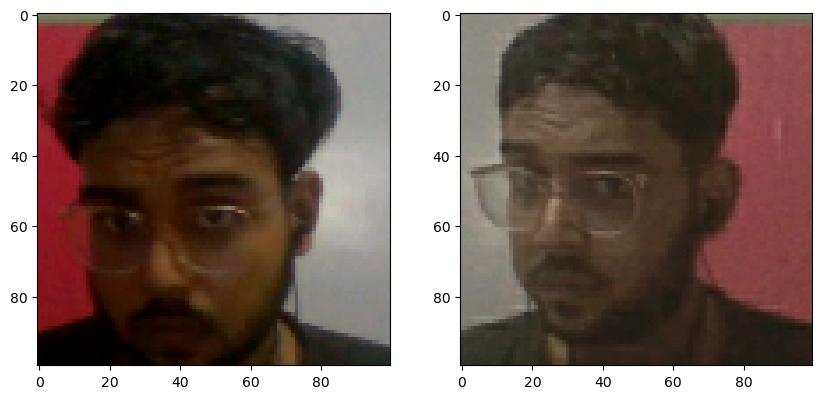

In [59]:
#Set plot size
plt.figure(figsize=(10,8))
#set first plot
plt.subplot(1,2,1)
plt.imshow(test_input[0])
#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])
#Renders cleanly
plt.show()

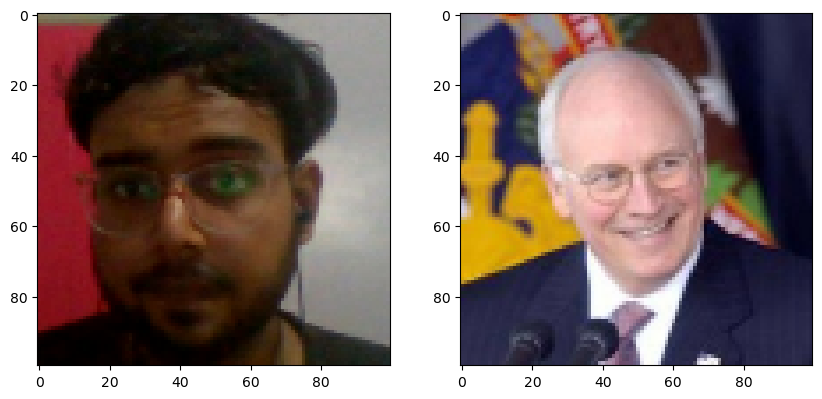

In [60]:
#Set plot size
plt.figure(figsize=(10,8))
#set first plot
plt.subplot(1,2,1)
plt.imshow(test_input[3])
#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])
#Renders cleanly
plt.show()

# Save Model

In [61]:
siamese_model.save("my_model.keras")

In [62]:
model = tf.keras.models.load_model('my_model.keras', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [63]:
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


array([[0.49953976],
       [0.5001606 ],
       [0.49850056],
       [0.49655762],
       [0.49977595],
       [0.49916303],
       [0.49720266]], dtype=float32)

In [64]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)        │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ validation_img (InputLayer)   │ (None, 100, 100, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Functional)        │ (None, 4096)              │      38,960,448 │ input_img[0][0],           │
│                               │                           │                 │ validation_img[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ l1_dist_1 (L1Dist)            │ (None, 4096)              │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding[1][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           4,097 │ l1_dist_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real Time Test

# Verification Function

In [71]:

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified
    

# OpenCV Real Time Verification

In [76]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    cv2.imshow('Verification',frame)
    
    #Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #Save input image to input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        results,verified = verify(model,0.5,0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()